Okay, lets try a word embedding model. Hopefully this will be a bit more robust than the first model I played with, since the words are better represented than with a simple tokenizer. 

First lets import our Libraries and Dataset.

In [1]:
%matplotlib inline

import os
import sys
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model

Using TensorFlow backend.


In [2]:
#Setup a few helpers
base_dir = ''
glove_dir = os.path.join(base_dir, 'glove.6B')
max_seq_len = 1000
max_num_words = 20000
embedding_dim = 100
validation_split = 0.2

In [3]:
#load the data into pandas for easy handling
data = pd.read_csv('train.csv')
#get a training and testing set
train, test = train_test_split(data, test_size = validation_split)

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
114416,63fa6ac1a39324be,"""\n\nyou make me laugh, albanian. with your sp...",0,0,0,0,0,0
82559,dcddcc8067c56c7e,Why? \n\nWhy don't you speak spanish?........,0,0,0,0,0,0
90363,f1d7893688a3e334,i anal rape little iraqie children while i typ...,1,1,1,0,1,1
29915,4f73d3d88ea95c82,"Well, i live in Uruguay and it is commonly bel...",0,0,0,0,0,0
139416,ea2c3f495f6b9444,Noting that it wasn't I who self-reverted...,0,0,0,0,0,0


In [5]:
test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
94009,fb5ea3a9d9a20dec,"""\n\n \n\nStop threatening people with your bl...",0,0,0,0,0,0
150522,6db0e9e06bbd0f17,"Mate, Why did you revert my user talk page?",0,0,0,0,0,0
130711,bb49cb1a118a8a4a,""" January 2012 (UTC)\nI used the italics for S...",0,0,0,0,0,0
123126,92ab8a8346477591,"""\nHere's a few more , and this one under the...",1,0,0,0,0,0
67623,b4f1b69eebcf8a59,Appreciate your comments. I will wait to post ...,0,0,0,0,0,0


In [6]:
#quick sanity check
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

So we see our dataset is adequately clean (Kaggle sure is nice). I've gone ahead and split the "testing" data into testing and training. I want to test on a subset of the data so I can validate the model. Once I'm confident in it, I can submit predictions to Kaggle for out-of-sample validation. That said, this is a luxury I seldom have so I don't want to lean on it like a crutch. 

In [7]:
#lets chop up the data into the pieces we want
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
labels = train[list_classes].values
comments_train = train["comment_text"]
comments_test = test["comment_text"]

In [8]:
comments_train.head()

114416    "\n\nyou make me laugh, albanian. with your sp...
82559         Why? \n\nWhy don't you speak spanish?........
90363     i anal rape little iraqie children while i typ...
29915     Well, i live in Uruguay and it is commonly bel...
139416         Noting that it wasn't I who self-reverted...
Name: comment_text, dtype: object

In [9]:
comments_test.head()

94009     "\n\n \n\nStop threatening people with your bl...
150522          Mate, Why did you revert my user talk page?
130711    " January 2012 (UTC)\nI used the italics for S...
123126    "\nHere's a few more , and this one  under the...
67623     Appreciate your comments. I will wait to post ...
Name: comment_text, dtype: object

In [11]:
labels[:5]

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [12]:
#You know, lets see how long these comments are in general
comments_train\
.apply(lambda x: len(x.split()))\
.describe()

count    127656.000000
mean         67.292536
std          99.041585
min           1.000000
25%          17.000000
50%          36.000000
75%          75.000000
max        1411.000000
Name: comment_text, dtype: float64

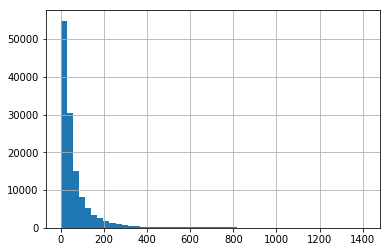

In [13]:
#some of those comments are crazy long, so lets get a better look. 
comments_train\
.apply(lambda x: len(x.split()))\
.hist(bins=50)

Okay, the dataset looks pretty hunky-dory. Lets tokenize it and get some embeddings. 

In [14]:
#before we figure out embeddings, 
#I'm gonna adjust the arbitrarily selected sequence length paramaters to fit this dataset.
max_seq_len = 200 
#lets cut this down to 200 for shorter input tensors and less empty space,
#we won't be loosing much of the dataset and it'll train quicker
max_num_words = 20000
embedding_dim = 100
#vocab size and Embedding dims still seem okay

In [15]:
#tokenize the comments
comment_tokenizer = Tokenizer(num_words=max_num_words)
comment_tokenizer.fit_on_texts(list(comments_train))
train_sequences = comment_tokenizer.texts_to_sequences(list(comments_train))

comment_word_index = comment_tokenizer.word_index

In [16]:
print(f"We got {len(comment_word_index)} Words")

We got 183414 Words


In [17]:
data_train = pad_sequences(train_sequences, maxlen=max_seq_len)

In [19]:
labels_categorical = to_categorical(np.asarray(labels))

In [21]:
print('Shape of data tensor:', data_train.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (127656, 200)
Shape of label tensor: (127656, 6)


All the shapes check out, trying to ID six categories, 